In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Library
import matplotlib.dates as mdates

In [2]:
path = os.getcwd()
path

'/Users/Wayne/Desktop/CentraleSupelec & ESSEC/Lecture/M2/M2_T2/Hackathon'

In [3]:
data = pd.read_csv(f"{path}/final_merge_data.csv")

/var/folders/1p/lfcd1twx1xnc84kx15cptk980000gn/T/ipykernel_44482/3461243975.py:1: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f"{path}/final_merge_data.csv")


In [4]:
data.head()

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,...,humidity,rain_1h,snow_1h,weather_main,weather_description,attendance,Unnamed: 0,NIGHT_SHOW,PARADE_1,PARADE_2
0,2018-01-01,2018-01-01 19:30:00,19,2018-01-01 19:45:00.000,Bumper Cars,5,18.0,148.0,254.749,254.75,...,83,NaN,NaN,Clouds,few clouds,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,2018-01-01 12:45:00,12,2018-01-01 13:00:00.000,Crazy Dance,5,1.0,46.0,250.001,250.00,...,93,0.92,NaN,Rain,light rain,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,2018-01-01 17:00:00,17,2018-01-01 17:15:00.000,Skyway,5,15.0,92.0,211.500,198.25,...,86,0.25,NaN,Rain,light rain,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,2018-01-01 13:30:00,13,2018-01-01 13:45:00.000,Monorail,70,11.0,145.0,223.751,223.75,...,93,0.82,NaN,Rain,light rain,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,2018-01-01 15:00:00,15,2018-01-01 15:15:00.000,Roller Coaster,20,2.0,51.0,75.000,75.00,...,85,2.34,NaN,Rain,moderate rain,NaN,NaN,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790295 entries, 0 to 1790294
Data columns (total 35 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   WORK_DATE                 object 
 1   DEB_TIME                  object 
 2   DEB_TIME_HOUR             int64  
 3   FIN_TIME                  object 
 4   ENTITY_DESCRIPTION_SHORT  object 
 5   WAIT_TIME_MAX             int64  
 6   NB_UNITS                  float64
 7   GUEST_CARRIED             float64
 8   CAPACITY                  float64
 9   ADJUST_CAPACITY           float64
 10  OPEN_TIME                 int64  
 11  UP_TIME                   int64  
 12  DOWNTIME                  int64  
 13  NB_MAX_UNIT               float64
 14  REF_CLOSING_DESCRIPTION   float64
 15  PARK                      object 
 16  YEAR                      int64  
 17  DAY_OF_WEEK               object 
 18  date                      object 
 19  hour                      int64  
 20  dt                      

# Data Preprocessing

In [6]:
df = data.drop(["Unnamed: 0", "REF_CLOSING_DESCRIPTION"], axis=1)

In [7]:
# Remove null value and negative value in "Attendance"
df = df[df["attendance"].notnull()]
df = df[df["attendance"] >= 0]

In [8]:
# df = df[df['ADJUST_CAPACITY'] > 0]
# df = df[df['GUEST_CARRIED'] > 0]

# df['UTILIZATION'] = df['GUEST_CARRIED'] / df['ADJUST_CAPACITY']

In [9]:
# Normally, NB_UNIT should not exceed NB_MAX_UNIT
df = df[(df["NB_MAX_UNIT"] - df["NB_UNITS"]) >= 0]

In [10]:
# Keep only data for "PostAventura"
df = df[df["PARK"] == "PortAventura World"]

In [11]:
# Convert date columns to datetime
df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])
df['DEB_TIME'] = pd.to_datetime(df['DEB_TIME'])
df['FIN_TIME'] = pd.to_datetime(df['FIN_TIME'])

In [12]:
# Clean Covid Time Data 
start_date = '2020-03-01'
end_date = '2021-08-01'

# Remove rows where WORK_DATE is within the specified range
df = df[~((df['WORK_DATE'] >= start_date) & (df['WORK_DATE'] <= end_date))]

In [13]:
# Fill nulls in weather columns
df['rain_1h'] = df['rain_1h'].fillna(0)
df['snow_1h'] = df['snow_1h'].fillna(0)

In [14]:
# Create binary columns where the presence of any string indicates an event
df['HAS_NIGHT_SHOW'] = df['NIGHT_SHOW'].notna().astype(int)
df['HAS_PARADE_1'] = df['PARADE_1'].notna().astype(int)
df['HAS_PARADE_2'] = df['PARADE_2'].notna().astype(int)

# Drop the original columns
df.drop(['NIGHT_SHOW', 'PARADE_1', 'PARADE_2'], axis=1, inplace=True)

In [15]:
# Add "Month" and "Minutes" columns to df by extracting from "DEB_TIME" column
df['month'] = df['DEB_TIME'].dt.month
df['minutes'] = df['DEB_TIME'].dt.minute

In [16]:
# Drop Unuseful Columns
# For the problem "feels_like" temperature is more important than "real" temperature because people
# will go out or not more depneds on feeling not real temperature
cols_to_drop = ["WORK_DATE", "DEB_TIME", 'FIN_TIME', 'GUEST_CARRIED', 'CAPACITY', "OPEN_TIME", "UP_TIME", 
                "DOWNTIME", "NB_MAX_UNIT", "PARK", "date", "hour", 'dt', 'dt_iso', "dew_point", "temp"]

df.drop(cols_to_drop, axis=1, inplace=True)

In [17]:
# Rename column 'DEB_TIME_HOUR' to 'hour'
df.rename(columns={'DEB_TIME_HOUR': 'hour'}, inplace=True)

In [18]:
# Reorder columns and put 'WAIT_TIME_MAX' at the end
df = df[['YEAR', 'month', 'DAY_OF_WEEK', 'hour', 'minutes', 'attendance', 'ENTITY_DESCRIPTION_SHORT', 'NB_UNITS',
         'ADJUST_CAPACITY', 'weather_main', 'weather_description', 'feels_like', 'humidity', 
         'rain_1h', 'snow_1h','HAS_NIGHT_SHOW', 'HAS_PARADE_1', 'HAS_PARADE_2', 'WAIT_TIME_MAX']]

# Convert all column names to lowercase
df.columns = df.columns.str.lower()

In [19]:
df.drop("year", axis=1, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 914224 entries, 196490 to 1753099
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   month                     914224 non-null  int32  
 1   day_of_week               914224 non-null  object 
 2   hour                      914224 non-null  int64  
 3   minutes                   914224 non-null  int32  
 4   attendance                914224 non-null  float64
 5   entity_description_short  914224 non-null  object 
 6   nb_units                  914224 non-null  float64
 7   adjust_capacity           914224 non-null  float64
 8   weather_main              914224 non-null  object 
 9   weather_description       914224 non-null  object 
 10  feels_like                914224 non-null  float64
 11  humidity                  914224 non-null  int64  
 12  rain_1h                   914224 non-null  float64
 13  snow_1h                   914224 non-null  

# Output Cleaned Data for Further Usage

In [102]:
# Save the DataFrame to a binary file (pickle format)
df.to_pickle(f'{path}/pretrained_dataset.pkl')

# Correlation Matrix

In [ ]:
numerical_features = ['attendance', 'nb_units', 'adjust_capacity', 'feels_like', 'humidity', 'rain_1h', 'snow_1h']
categorical_features = ['day_of_week', "entity_description_short", 'weather_main', 'weather_description']
binary_features = ['has_night_show', 'has_parade_1', 'has_parade_2']
time_features = ['month', 'hour', 'minutes']

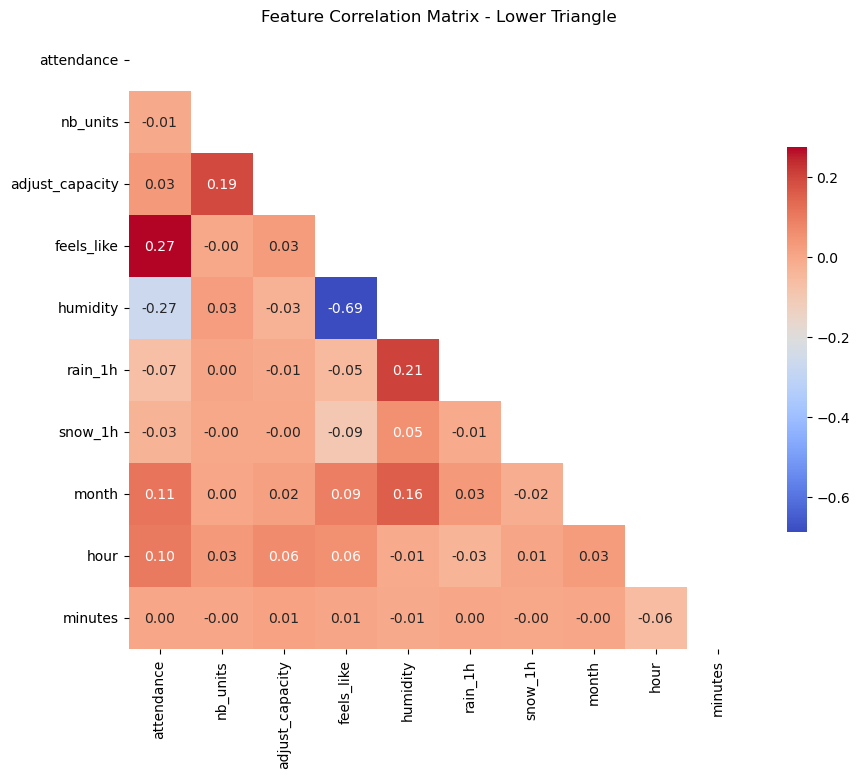

In [54]:
corr_matrix = df[numerical_features + time_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})

plt.title('Feature Correlation Matrix - Lower Triangle')
plt.show()

# Train / Test Split

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [23]:
# Define Evaluation Matrix
def calculate_custom_accuracy(y_true, y_pred, threshold):
    """Calculate the custom accuracy based on a threshold."""
    differences = np.abs(y_true - y_pred)
    accurate_predictions = differences <= threshold
    accuracy = np.mean(accurate_predictions)
    return accuracy

In [25]:
# One-hot encode categorical variables
one_hot_encoder = OneHotEncoder()

# Standardize numerical variables
standard_scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot_encoder, categorical_features),
        ('num', standard_scaler, numerical_features)
    ],
    remainder='passthrough'
)

X = df.drop('wait_time_max', axis=1)
y = df['wait_time_max']

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Preprocess the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Baseline Model - Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Calculate evaluation metrics
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Linear Regression MAE: {mae_lr}")
print(f"Linear Regression R²: {r2_lr}")

Linear Regression RMSE: 15.71851047118056
Linear Regression MAE: 10.867983207536538
Linear Regression R²: 0.5295762477214077


In [29]:
accuracy_lr = calculate_custom_accuracy(y_test, y_pred_lr, threshold=5)

print(f"Custom Accuracy (within 5 minutes): {accuracy_lr * 100:.2f}%")

Custom Accuracy (within 5 minutes): 33.82%


# Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

# Assuming 'preprocessor' is defined elsewhere and suitable for your data
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=42))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)

/Users/Wayne/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# Calculate evaluation metrics
rmse_logreg = np.sqrt(mean_squared_error(y_test, y_pred_logreg))
mae_logreg = mean_absolute_error(y_test, y_pred_logreg)
r2_logreg = r2_score(y_test, y_pred_logreg)

print(f"Logistic Regression RMSE: {rmse_logreg}")
print(f"Logistic Regression MAE: {mae_logreg}")
print(f"Logistic Regression R²: {r2_logreg}")

accuracy_logreg = calculate_custom_accuracy(y_test, y_pred_logreg, threshold=5)

print(f"Custom Accuracy (within 5 minutes): {accuracy_logreg * 100:.2f}%")

Logistic Regression RMSE: 22.26958152412247
Logistic Regression MAE: 13.886406519182914
Logistic Regression R²: 0.05574220978776667
Custom Accuracy (within 5 minutes): 47.84%


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=10))
])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

# Calculate evaluation metrics
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN Regression RMSE: {rmse_knn}")
print(f"KNN Regression MAE: {mae_knn}")
print(f"KNN Regression R²: {r2_knn}")

In [ ]:
accuracy_knn = calculate_custom_accuracy(y_test, y_pred_knn, threshold=5)

print(f"Custom Accuracy (within 5 minutes): {accuracy_knn * 100:.2f}%")

# Decision Tree

In [30]:
from sklearn.tree import DecisionTreeRegressor

# Define the pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Fit the model
dt_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_pipeline.predict(X_test)

In [96]:
# Calculate evaluation metrics
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree Regression RMSE: {rmse_dt}")
print(f"Decision Tree Regression MAE: {mae_dt}")
print(f"Decision Tree Regression R²: {r2_dt}")

# If you have the custom accuracy function defined
accuracy_dt = calculate_custom_accuracy(y_test, y_pred_dt, threshold=10)
print(f"Custom Accuracy (within 5 minutes): {accuracy_dt * 100:.2f}%")

Decision Tree Regression RMSE: 9.757001369266687
Decision Tree Regression MAE: 4.037107932948673
Decision Tree Regression R²: 0.8187411600860339
Custom Accuracy (within 5 minutes): 89.51%


In [32]:
feature_names_transformed = []

# Extracting categories for one-hot encoded features
categories = dt_pipeline.named_steps['preprocessor'].named_transformers_['cat'].categories_
for original_feature, categories_for_feature in zip(categorical_features, categories):
    feature_names_transformed.extend([f"{original_feature}_{category}" for category in categories_for_feature])

# Including numerical features (assuming they're passed through without changes)
feature_names_transformed.extend(numerical_features)

# Extracting feature importances from the DecisionTreeRegressor within the pipeline
feature_importances = dt_pipeline.named_steps['regressor'].feature_importances_

# Pairing each transformed feature name with its corresponding importance
importances = dict(zip(feature_names_transformed, feature_importances))

# Sorting the features by their importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Printing the sorted feature importances
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

attendance: 0.13939247714880384
entity_description_short_Spiral Slide: 0.12050723460378454
nb_units: 0.07976421687101948
entity_description_short_Free Fall: 0.0731762490079931
entity_description_short_Swing Ride: 0.0722528829114575
entity_description_short_Giant Wheel: 0.0679134716675247
feels_like: 0.04966393965168636
adjust_capacity: 0.04640034334475601
humidity: 0.028539325720142433
entity_description_short_Go-Karts: 0.012953139247661711
entity_description_short_Oz Theatre: 0.0067932737607378415
rain_1h: 0.004541404011994475
entity_description_short_Haunted House: 0.0044164938303494
day_of_week_Sunday: 0.003953250094903164
day_of_week_Saturday: 0.003942352360146653
day_of_week_Friday: 0.003832389360127324
day_of_week_Tuesday: 0.003164394652906207
entity_description_short_Spinning Coaster: 0.0030717507213849035
day_of_week_Monday: 0.002938230018298533
weather_description_overcast clouds: 0.0028867127282536267
day_of_week_Wednesday: 0.0028274915198800445
weather_description_broken clo

### Confusion Matrix for Regression

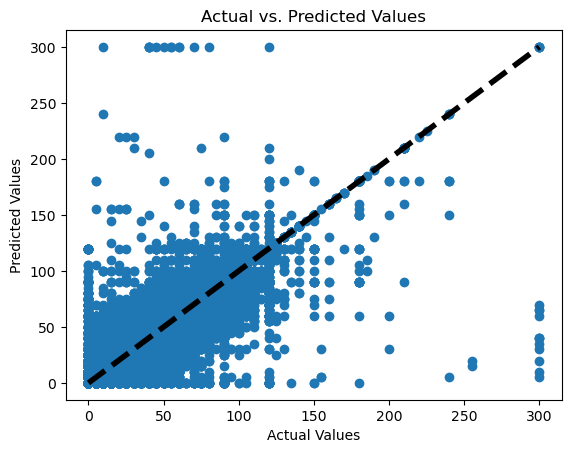

In [33]:
plt.scatter(y_test, y_pred_dt)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

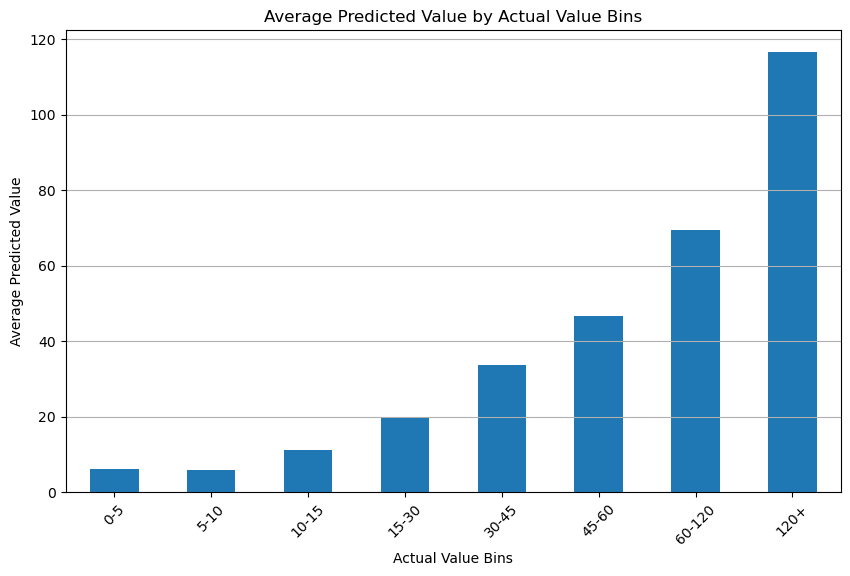

In [98]:
# Define bins and labels
bins = [0, 5, 10, 15, 30, 45, 60, 120, np.inf]
labels = ['0-5', '5-10', '10-15', '15-30', '30-45', '45-60' , '60-120', '120+']

# Categorize y_test into bins
y_test_bins = pd.cut(y_test, bins=bins, labels=labels, right=False)

# Create a DataFrame for easier handling
df_comparison = pd.DataFrame({'Actual': y_test_bins, 'Predicted': y_pred_dt})

# Calculate mean predicted value for each bin
mean_predicted_per_bin = df_comparison.groupby('Actual')['Predicted'].mean()

# Plotting
plt.figure(figsize=(10, 6))
mean_predicted_per_bin.plot(kind='bar')
plt.xlabel('Actual Value Bins')
plt.ylabel('Average Predicted Value')
plt.title('Average Predicted Value by Actual Value Bins')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.grid(axis='y')

# Show plot
plt.show()

### Bar Chart of Top Features

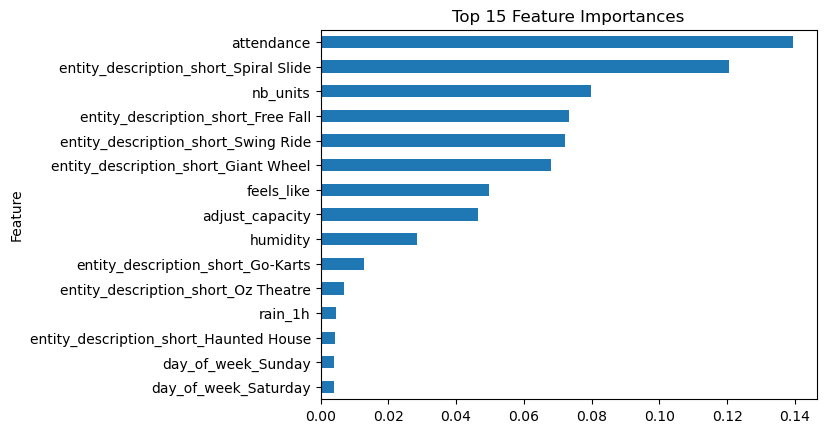

In [34]:
top_features = pd.DataFrame(sorted_importances[:15], columns=['Feature', 'Importance'])
top_features.plot(kind='barh', x='Feature', y='Importance', legend=None)
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train Random Forest model
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# Calculate evaluation metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression RMSE: {rmse_rf}")
print(f"Random Forest Regression MAE: {mae_rf}")
print(f"Random Forest Regression R²: {r2_rf}")

In [ ]:
accuracy_rf = calculate_custom_accuracy(y_test, y_pred_rf, threshold=5)

print(f"Custom Accuracy (within 5 minutes): {accuracy_rf * 100:.2f}%")

In [ ]:
feature_names_transformed = []

# For one-hot encoded features
categories = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].categories_
for original_feature, categories_for_feature in zip(categorical_features, categories):
    feature_names_transformed.extend([f"{original_feature}_{category}" for category in categories_for_feature])

# For numerical features (assuming they're passed through without changes)
feature_names_transformed.extend(numerical_features)

# Get feature importances
feature_importances = rf_pipeline.named_steps['regressor'].feature_importances_

# Create a dictionary to hold feature names and their importances
importances = dict(zip(feature_names_transformed, feature_importances))

# Sort the dictionary by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Print the sorted importances
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

# XGBoost

In [52]:
from xgboost import XGBRegressor

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=500, learning_rate=0.1, random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

In [53]:
# Calculate evaluation metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R²: {r2_xgb}")

accuracy_xgb = calculate_custom_accuracy(y_test, y_pred_xgb, threshold=5)

print(f"Custom Accuracy (within 5 minutes): {accuracy_xgb * 100:.2f}%")

XGBoost RMSE: 11.520177639926326
XGBoost MAE: 7.009554679579264
XGBoost R²: 0.7274247774205767
Custom Accuracy (within 5 minutes): 55.29%


# Catboost

In [74]:
from catboost import CatBoostRegressor

catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(iterations=100, learning_rate=0.1, silent=True, random_state=42))
])

catboost_pipeline.fit(X_train, y_train)
y_pred_catboost = catboost_pipeline.predict(X_test)

In [94]:
# Calculate evaluation metrics
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print(f"Catboost Regression RMSE: {rmse_catboost}")
print(f"Catboost Tree Regression MAE: {mae_catboost}")
print(f"Catboost Tree Regression R²: {r2_catboost}")

accuracy_catboost = calculate_custom_accuracy(y_test, y_pred_catboost, threshold=5)
print(f"Custom Accuracy (within 5 minutes): {accuracy_catboost * 100:.2f}%")

Catboost Regression RMSE: 13.722135849955354
Catboost Tree Regression MAE: 8.88969795688371
Catboost Tree Regression R²: 0.6132668035704101
Custom Accuracy (within 5 minutes): 45.33%


# Voting Regressor (Decision Tree / Random Forest)

In [54]:
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import make_pipeline

# Define the individual regressors within their pipelines
dt_regressor = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
rf_regressor = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))

# Construct the VotingRegressor
voting_regressor = VotingRegressor(
    estimators=[
        ('dt', dt_regressor),
        ('rf', rf_regressor)
    ]
)

# Fit the VotingRegressor to the training data
voting_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_voting = voting_regressor.predict(X_test)

# Calculate evaluation metrics for the VotingRegressor
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
mae_voting = mean_absolute_error(y_test, y_pred_voting)
r2_voting = r2_score(y_test, y_pred_voting)

print(f"Voting Regressor RMSE: {rmse_voting}")
print(f"Voting Regressor MAE: {mae_voting}")
print(f"Voting Regressor R²: {r2_voting}")

Voting Regressor RMSE: 12.656291697096622
Voting Regressor MAE: 5.296046667400489
Voting Regressor R²: 0.6710113047004174


In [55]:
accuracy_voting = calculate_custom_accuracy(y_test, y_pred_voting, threshold=5)
print(f"Custom Accuracy (within 5 minutes): {accuracy_voting * 100:.2f}%")

Custom Accuracy (within 5 minutes): 74.15%


# Neural Network

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

In [58]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Simple NN

In [144]:
# Convert datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train_transformed.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test_transformed.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define the split sizes. Let's say we want to use 20% of the training data for validation
total_train_samples = len(train_dataset)
val_size = int(0.2 * total_train_samples)
train_size = total_train_samples - val_size

# Split the dataset
train_ds, val_ds = random_split(train_dataset, [train_size, val_size], generator = torch.Generator().manual_seed(42))

# Define the DataLoaders for training, validation, and test sets
train_loader = DataLoader(dataset=train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [195]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        # self.dropout1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)
        # self.dropout2 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
        self.bn3 = nn.BatchNorm1d(hidden_size//4)
        # self.dropout3 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(hidden_size//4, 1)

        self.LeakyReLU = nn.LeakyReLU()

    def forward(self, x):
        x = self.LeakyReLU(self.bn1(self.fc1(x)))
        # x = self.dropout1(x)
        x = self.LeakyReLU(self.bn2(self.fc2(x)))
        # x = self.dropout2(x)
        x = self.LeakyReLU(self.bn3(self.fc3(x)))
        # x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [196]:
model = RegressionModel(X_train_transformed.shape[1], hidden_size = 256).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [197]:
best_val_loss = float("inf")
patience = 8
trigger_times = 0

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    val_loss = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    # Early Stopping mechanism
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break  # Stop training

Epoch [1/100], Training Loss: 1014.8007, Validation Loss: 969.6417
Epoch [2/100], Training Loss: 1349.4746, Validation Loss: 953.3307
Epoch [3/100], Training Loss: 713.8409, Validation Loss: 675.5169
Epoch [4/100], Training Loss: 856.9788, Validation Loss: 645.7392
Epoch [5/100], Training Loss: 581.4509, Validation Loss: 814.1269
Epoch [6/100], Training Loss: 441.3726, Validation Loss: 499.7142
Epoch [7/100], Training Loss: 306.1434, Validation Loss: 428.0274
Epoch [8/100], Training Loss: 415.4288, Validation Loss: 426.9554
Epoch [9/100], Training Loss: 382.0429, Validation Loss: 461.6227
Epoch [10/100], Training Loss: 298.1849, Validation Loss: 371.0443
Epoch [11/100], Training Loss: 343.0798, Validation Loss: 391.0786
Epoch [12/100], Training Loss: 717.0828, Validation Loss: 454.7066
Epoch [13/100], Training Loss: 391.2104, Validation Loss: 482.7536
Epoch [14/100], Training Loss: 257.0495, Validation Loss: 521.1651
Epoch [15/100], Training Loss: 343.2537, Validation Loss: 397.1289
Ep

In [198]:
# After training, evaluate the model's performance on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
with torch.no_grad():
    for test_inputs, _ in test_loader:  # No need for targets here
        test_inputs = test_inputs.to(device)
        test_outputs = model(test_inputs)
        predictions.append(test_outputs.cpu())  # Collect predictions
predictions = torch.cat(predictions, dim=0)

# Convert predictions and y_test to NumPy for evaluation metrics calculation
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_np, predictions_np))
mae = mean_absolute_error(y_test_np, predictions_np)
r2 = r2_score(y_test_np, predictions_np)

print(f"Deep Learning Model (PyTorch) RMSE: {rmse}")
print(f"Deep Learning Model (PyTorch) MAE: {mae}")
print(f"Deep Learning Model (PyTorch) R²: {r2}")

Deep Learning Model (PyTorch) RMSE: 22.00676727294922
Deep Learning Model (PyTorch) MAE: 15.309794425964355
Deep Learning Model (PyTorch) R²: 0.05303830034479884


In [199]:
accuracy_nn = calculate_custom_accuracy(y_test_np, predictions_np, threshold=5)
print(f"Custom Accuracy (within 5 minutes): {accuracy_nn * 100:.2f}%")

Custom Accuracy (within 5 minutes): 26.90%


## Fully Connected Neural Network

In [237]:
class FCNNRegression(nn.Module):
    def __init__(self, input_features, output_dim=1):
        super(FCNNRegression, self).__init__()
        self.fc1 = nn.Linear(input_features, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, output_dim)

        self.dropout1 = nn.Dropout(0.1)  # Added dropout for regularization
        self.dropout2 = nn.Dropout(0.1)  # Added dropout for regularization
        self.dropout3 = nn.Dropout(0.1)  # Added dropout for regularization

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [240]:
# Assuming you know the number of features in your input data
input_features = X_train_transformed.shape[1]
model = FCNNRegression(input_features).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [226]:
best_val_loss = float("inf")
patience = 20
trigger_times = 0

# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    val_loss = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    # Early Stopping mechanism
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break  # Stop training

Epoch [1/100], Training Loss: 337.2324, Validation Loss: 371.7150
Epoch [2/100], Training Loss: 366.9820, Validation Loss: 399.1021
Epoch [3/100], Training Loss: 801.0062, Validation Loss: 377.9130
Epoch [4/100], Training Loss: 340.5701, Validation Loss: 382.1425
Epoch [5/100], Training Loss: 356.3946, Validation Loss: 386.1535
Epoch [6/100], Training Loss: 266.1385, Validation Loss: 379.5737
Epoch [7/100], Training Loss: 388.7727, Validation Loss: 354.8846
Epoch [8/100], Training Loss: 373.7204, Validation Loss: 375.6821
Epoch [9/100], Training Loss: 412.2842, Validation Loss: 389.5251
Epoch [10/100], Training Loss: 197.3150, Validation Loss: 372.4987
Epoch [11/100], Training Loss: 311.9633, Validation Loss: 385.2521
Epoch [12/100], Training Loss: 218.8393, Validation Loss: 376.0966
Epoch [13/100], Training Loss: 271.4353, Validation Loss: 373.6968
Epoch [14/100], Training Loss: 359.7141, Validation Loss: 357.9829
Epoch [15/100], Training Loss: 333.9897, Validation Loss: 375.3983
Epoc

In [227]:
# After training, evaluate the model's performance on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
with torch.no_grad():
    for test_inputs, _ in test_loader:  # No need for targets here
        test_inputs = test_inputs.to(device)
        test_outputs = model(test_inputs)
        predictions.append(test_outputs.cpu())  # Collect predictions
predictions = torch.cat(predictions, dim=0)

# Convert predictions and y_test to NumPy for evaluation metrics calculation
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_np, predictions_np))
mae = mean_absolute_error(y_test_np, predictions_np)
r2 = r2_score(y_test_np, predictions_np)

print(f"Deep Learning Model (PyTorch) RMSE: {rmse}")
print(f"Deep Learning Model (PyTorch) MAE: {mae}")
print(f"Deep Learning Model (PyTorch) R²: {r2}")

Deep Learning Model (PyTorch) RMSE: 18.623966217041016
Deep Learning Model (PyTorch) MAE: 12.747228622436523
Deep Learning Model (PyTorch) R²: 0.3217899239779195


In [228]:
accuracy_nn = calculate_custom_accuracy(y_test_np, predictions_np, threshold=5)
print(f"Custom Accuracy (within 5 minutes): {accuracy_nn * 100:.2f}%")

Custom Accuracy (within 5 minutes): 28.21%


## LSTM

In [ ]:
# Convert datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train_transformed.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test_transformed.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# For LSTM Model
# X_train_tensor = torch.tensor(X_train_transformed.astype(np.float32)).view(-1, 1, X_train_transformed.shape[1])
# X_test_tensor = torch.tensor(X_test_transformed.astype(np.float32)).view(-1, 1, X_test_transformed.shape[1])

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define the split sizes. Let's say we want to use 20% of the training data for validation
total_train_samples = len(train_dataset)
val_size = int(0.2 * total_train_samples)
train_size = total_train_samples - val_size

# Split the dataset
train_ds, val_ds = random_split(train_dataset, [train_size, val_size], generator = torch.Generator().manual_seed(42))

# Define the DataLoaders for training, validation, and test sets
train_loader = DataLoader(dataset=train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [122]:
class LSTMRegressionModel(nn.Module): #LSTM
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTMRegressionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = LSTMRegressionModel(input_size=X_train_transformed.shape[1], hidden_size=50, num_layers=2).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
best_val_loss = float("inf")
patience = 8
trigger_times = 0

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    val_loss = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    # Early Stopping mechanism
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break  # Stop training

In [ ]:
# After training, evaluate the model's performance on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
with torch.no_grad():
    for test_inputs, _ in test_loader:  # No need for targets here
        test_inputs = test_inputs.to(device)
        test_outputs = model(test_inputs)
        predictions.append(test_outputs.cpu())  # Collect predictions
predictions = torch.cat(predictions, dim=0)

# Convert predictions and y_test to NumPy for evaluation metrics calculation
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_np, predictions_np))
mae = mean_absolute_error(y_test_np, predictions_np)
r2 = r2_score(y_test_np, predictions_np)

print(f"Deep Learning Model (PyTorch) RMSE: {rmse}")
print(f"Deep Learning Model (PyTorch) MAE: {mae}")
print(f"Deep Learning Model (PyTorch) R²: {r2}")

In [ ]:
accuracy_nn = calculate_custom_accuracy(y_test_np, predictions_np, threshold=5)
print(f"Custom Accuracy (within 5 minutes): {accuracy_nn * 100:.2f}%")

## Transformer

In [136]:
class TransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim=1):
        super(TransformerRegression, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)  # Ensure batch_first is True
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_linear = nn.Linear(d_model, output_dim)

    def forward(self, src):
        # Add a sequence length of 1
        src = src.unsqueeze(1)  # Change shape from [batch_size, features] to [batch_size, 1, features]
        src = self.input_embedding(src)
        # No need to permute src anymore since batch_first=True handles it
        output = self.transformer_encoder(src)
        # No need to permute back, directly access the required output
        output = self.output_linear(output[:, 0, :])  # Use the output corresponding to the added sequence
        return output

In [139]:
# Model parameters - these need to be chosen based on your specific task
input_dim = X_train_transformed.shape[1]  # Number of features
d_model = 512  # The size of the transformer embeddings
nhead = 8  # The number of heads in the multiheadattention models
num_encoder_layers = 3  # The number of sub-encoder-layers in the encoder
dim_feedforward = 2048  # The dimension of the feedforward network model in nn.TransformerEncoder

model = TransformerRegression(input_dim=input_dim, d_model=d_model, nhead=nhead,
                              num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
best_val_loss = float("inf")
patience = 8
trigger_times = 0

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    val_loss = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    # Early Stopping mechanism
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break  # Stop training

In [142]:
# After training, evaluate the model's performance on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
with torch.no_grad():
    for test_inputs, _ in test_loader:  # No need for targets here
        test_inputs = test_inputs.to(device)
        test_outputs = model(test_inputs)
        predictions.append(test_outputs.cpu())  # Collect predictions
predictions = torch.cat(predictions, dim=0)

# Convert predictions and y_test to NumPy for evaluation metrics calculation
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_np, predictions_np))
mae = mean_absolute_error(y_test_np, predictions_np)
r2 = r2_score(y_test_np, predictions_np)

print(f"Deep Learning Model (PyTorch) RMSE: {rmse}")
print(f"Deep Learning Model (PyTorch) MAE: {mae}")
print(f"Deep Learning Model (PyTorch) R²: {r2}")

Deep Learning Model (PyTorch) RMSE: 22.623247146606445
Deep Learning Model (PyTorch) MAE: 18.08173370361328
Deep Learning Model (PyTorch) R²: -0.0007594950992264593


In [143]:
accuracy_nn = calculate_custom_accuracy(y_test_np, predictions_np, threshold=5)
print(f"Custom Accuracy (within 5 minutes): {accuracy_nn * 100:.2f}%")

Custom Accuracy (within 5 minutes): 13.85%


# Random Data Generation

In [72]:
# Define possible values for categorical variables
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weather_main = ['Clear', 'Clouds', 'Rain', 'Snow']
weather_description = ['overcast clouds', 'broken clouds', 'sky is clear', 'light rain',
       'scattered clouds', 'moderate rain', 'few clouds', 'light snow',
       'snow', 'heavy intensity rain']
# entity_description_short = ['Dizzy Dropper', 'Crazy Dance', 'Rapids Ride', 'Oz Theatre',
#        'Inverted Coaster', 'Merry Go Round', 'Spiral Slide',
#        'Bungee Jump', 'Drop Tower', 'Swing Ride', 'Go-Karts',
#        'Himalaya Ride', 'Kiddie Coaster', 'Roller Coaster',
#        'Spinning Coaster', 'Superman Ride', 'Giant Wheel', 'Circus Train',
#        'Water Ride', 'Zipline', 'Bumper Cars', 'Haunted House',
#        'Giga Coaster', 'Flying Coaster', 'Free Fall', 'Vertical Drop']

entity_description_short = ['Oz Theatre','Go-Karts', 'Spiral Slide']

# Random generation function
def generate_random_data(num_rows):
    np.random.seed(42)  # For reproducibility
    data = {
        'month': np.random.randint(1, 13, num_rows),
        'day_of_week': np.random.choice(days_of_week, num_rows),
        'hour': np.random.randint(9, 22, num_rows),
        'minutes': np.random.choice([0, 15, 30, 45], num_rows),
        'attendance': np.random.uniform(4000, 80000, num_rows).round(0),
        'entity_description_short': np.random.choice(entity_description_short, num_rows),
        'nb_units': np.random.uniform(0, 130, num_rows).round(4),
        'adjust_capacity': np.random.uniform(0, 756, num_rows).round(4),
        'weather_main': np.random.choice(weather_main, num_rows),
        'weather_description': np.random.choice(weather_description, num_rows),
        'feels_like': np.random.uniform(-5, 40, num_rows).round(2),
        'humidity': np.random.randint(0, 100, num_rows),
        'rain_1h': np.random.uniform(0, 9, num_rows).round(1),
        'snow_1h': np.random.uniform(0, 3, num_rows).round(1),
        'has_night_show': np.random.randint(0, 2, num_rows),
        'has_parade_1': np.random.randint(0, 2, num_rows),
        'has_parade_2': np.random.randint(0, 2, num_rows),
    }
    return pd.DataFrame(data)

# Generate 20 new rows
synthetic_data = generate_random_data(20)

synthetic_data

,month,day_of_week,hour,minutes,attendance,entity_description_short,nb_units,adjust_capacity,weather_main,weather_description,feels_like,humidity,rain_1h,snow_1h,has_night_show,has_parade_1,has_parade_2
0,7,Thursday,11,0,43525.0,Spiral Slide,118.9448,152.4997,Snow,snow,39.90,15,3.6,2.5,1,1,1
1,4,Saturday,20,15,45550.0,Oz Theatre,110.5050,677.1973,Clouds,scattered clouds,7.01,96,4.7,2.6,1,0,0
2,11,Saturday,15,45,18049.0,Oz Theatre,58.4286,359.3799,Rain,overcast clouds,38.95,72,7.5,1.2,1,0,1
3,8,Tuesday,12,45,77688.0,Oz Theatre,12.4033,425.8363,Snow,sky is clear,13.50,58,6.1,2.7,1,1,0
4,5,Thursday,17,30,62910.0,Spiral Slide,48.2064,525.8102,Clear,heavy intensity rain,-3.51,69,6.6,2.6,1,1,1
5,7,Friday,11,45,75402.0,Oz Theatre,86.9494,105.3346,Rain,light snow,10.53,79,1.9,2.8,0,0,0
6,10,Monday,13,30,72007.0,Oz Theatre,86.5699,456.9395,Clouds,moderate rain,23.55,92,4.9,2.4,0,0,1
7,3,Thursday,11,45,49440.0,Spiral Slide,76.8687,408.1199,Clear,light snow,25.63,2,6.3,2.0,0,1,1
8,7,Tuesday,15,0,74062.0,Spiral Slide,35.7138,153.5143,Clear,snow,18.89,19,2.1,1.7,1,0,1
9,11,Saturday,13,45,10725.0,Spiral Slide,72.9616,712.7973,Clear,light rain,15.15,58,1.6,1.1,0,1,0


In [76]:
y_pred_dt = dt_pipeline.predict(synthetic_data)
synthetic_data["max_wait_time"] = y_pred_dt
synthetic_data[["entity_description_short","day_of_week", "hour", "attendance", "max_wait_time"]].sort_values(
    ["entity_description_short", "day_of_week"], ascending=False)

,entity_description_short,day_of_week,hour,attendance,max_wait_time
14,Spiral Slide,Wednesday,17,24623.0,15.0
8,Spiral Slide,Tuesday,15,74062.0,50.0
17,Spiral Slide,Tuesday,18,25351.0,90.0
0,Spiral Slide,Thursday,11,43525.0,120.0
4,Spiral Slide,Thursday,17,62910.0,120.0
7,Spiral Slide,Thursday,11,49440.0,180.0
11,Spiral Slide,Thursday,15,7437.0,120.0
9,Spiral Slide,Saturday,13,10725.0,45.0
12,Spiral Slide,Monday,10,28725.0,75.0
15,Oz Theatre,Wednesday,20,66984.0,0.0


In [88]:
# To Examine the prediction performance of our model
e = "Oz Theatre"
d = "Saturday"
h = 20
a_max = 50000
a_min = 30000

x = (df["entity_description_short"] == e) & (
    df["day_of_week"] == d) & (
    df["hour"] == h) & (
    df["attendance"] <= a_max) &(
    df["attendance"] >= a_min)

df[x].describe()

,month,hour,minutes,attendance,nb_units,adjust_capacity,feels_like,humidity,rain_1h,snow_1h,has_night_show,has_parade_1,has_parade_2,wait_time_max
count,9.000000,9.0,9.000000,9.000000,9.0,9.0,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.0,9.000000
mean,3.222222,20.0,25.000000,42007.555556,2.0,387.5,13.466667,78.333333,0.058889,0.0,0.444444,0.444444,0.0,8.888889
std,2.635231,0.0,18.371173,7231.268096,0.0,0.0,17.829898,22.135944,0.176667,0.0,0.527046,0.527046,0.0,3.333333
min,1.000000,20.0,0.000000,35765.000000,2.0,387.5,-2.550000,55.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
25%,1.000000,20.0,15.000000,35765.000000,2.0,387.5,-2.550000,55.000000,0.000000,0.0,0.000000,0.000000,0.0,10.000000
50%,1.000000,20.0,30.000000,36504.000000,2.0,387.5,2.680000,97.000000,0.000000,0.0,0.000000,0.000000,0.0,10.000000
75%,6.000000,20.0,45.000000,49626.000000,2.0,387.5,32.180000,97.000000,0.000000,0.0,1.000000,1.000000,0.0,10.000000
max,6.000000,20.0,45.000000,49626.000000,2.0,387.5,32.180000,97.000000,0.530000,0.0,1.000000,1.000000,0.0,10.000000
